# 1.1. What is the business objective?
The primary business objective is to:

Determine the investment viability of a suburban area based on data-driven insights using SVM, focusing on population density and income levels.

By doing this, the construction firm wants to:

Minimize the risk of unsold properties.

Identify whether the demographics and economic profile of the locality support development.

Make strategic decisions on whether to proceed with infrastructure projects in that area.

# 1.2. Are there any constraints?


Data Availability & Quality:

Incomplete or outdated data on income levels or population may affect prediction accuracy.

Model Accuracy:

SVM performance may be limited if the data is not clearly separable or if key features are missing.

Interpretability:

SVM, especially with non-linear kernels (e.g., RBF), can be less interpretable than other models like decision trees, which might be a concern for business stakeholders.

Scalability:

SVMs can be computationally intensive for large datasets, which could be a limitation in real-time analysis or larger regions.

External Factors:

Market trends, real estate policies, and interest rates are not captured in the model but can significantly affect viability.

# Load the Dataset



In [92]:
import pandas as pd

# Load the dataset
train= pd.read_csv("SalaryData_Train.csv")
test=pd.read_csv("SalaryData_Test.csv")

# Display the first few rows
print(train.head())
print(test.head())

   age          workclass   education  educationno        maritalstatus  \
0   39          State-gov   Bachelors           13        Never-married   
1   50   Self-emp-not-inc   Bachelors           13   Married-civ-spouse   
2   38            Private     HS-grad            9             Divorced   
3   53            Private        11th            7   Married-civ-spouse   
4   28            Private   Bachelors           13   Married-civ-spouse   

           occupation    relationship    race      sex  capitalgain  \
0        Adm-clerical   Not-in-family   White     Male         2174   
1     Exec-managerial         Husband   White     Male            0   
2   Handlers-cleaners   Not-in-family   White     Male            0   
3   Handlers-cleaners         Husband   Black     Male            0   
4      Prof-specialty            Wife   Black   Female            0   

   capitalloss  hoursperweek          native  Salary  
0            0            40   United-States   <=50K  
1           

# 3.1 Data Cleaning & Feature Engineering

In [94]:
print(train.isnull().sum())
print(test.isnull().sum())

age              0
workclass        0
education        0
educationno      0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
native           0
Salary           0
dtype: int64
age              0
workclass        0
education        0
educationno      0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
native           0
Salary           0
dtype: int64


In [98]:
# Replace '?' with NaN and drop or impute
train.replace(' ?', pd.NA, inplace=True)
print(train.isna().sum())

# Drop rows with missing values for simplicity
train.dropna(inplace=True)


# Replace '?' with NaN and drop or impute
test.replace(' ?', pd.NA, inplace=True)
print(test.isna().sum())

# Drop rows with missing values for simplicity
test.dropna(inplace=True)

age              0
workclass        0
education        0
educationno      0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
native           0
Salary           0
dtype: int64
age              0
workclass        0
education        0
educationno      0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
native           0
Salary           0
dtype: int64


In [100]:
train= train.applymap(lambda x: x.strip() if isinstance(x, str) else x)
test= test.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [102]:
# Binary encode target
train['Salary'] = train['Salary'].apply(lambda x: 1 if x == '>50K' else 0)

# One-Hot Encode remaining categorical columns
categorical_cols = train.select_dtypes(include='object').columns
train = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

# Binary encode target
test['Salary'] = test['Salary'].apply(lambda x: 1 if x == '>50K' else 0)

# One-Hot Encode remaining categorical columns
categorical_cols = test.select_dtypes(include='object').columns
test = pd.get_dummies(test, columns=categorical_cols, drop_first=True)


# 3.2 Outlier Treatment

In [104]:
import numpy as np

def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper, upper,
                 np.where(df[column] < lower, lower, df[column]))

# Apply to key numeric columns
for col in ['age', 'hoursperweek', 'capitalgain', 'capitalloss']:
    cap_outliers(train, col)

# Apply to key numeric columns
for col in ['age', 'hoursperweek', 'capitalgain', 'capitalloss']:
    cap_outliers(test, col)


# 4.1 Summary

In [106]:
# Summary of numerical features
print(train.describe())

# Summary of categorical (original) before encoding
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']

for col in categorical_columns:
    print(f"\n{col} value counts:\n", train[col].value_counts())

# Summary of numerical features
print(test.describe())

# Summary of categorical (original) before encoding
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']

for col in categorical_columns:
    print(f"\n{col} value counts:\n", test[col].value_counts())


                age   educationno  capitalgain  capitalloss  hoursperweek  \
count  30161.000000  30161.000000      30161.0      30161.0  30161.000000   
mean      38.404612     10.121316          0.0          0.0     41.419399   
std       13.026672      2.550037          0.0          0.0      6.146043   
min       17.000000      1.000000          0.0          0.0     32.500000   
25%       28.000000      9.000000          0.0          0.0     40.000000   
50%       37.000000     10.000000          0.0          0.0     40.000000   
75%       47.000000     13.000000          0.0          0.0     45.000000   
max       75.500000     16.000000          0.0          0.0     52.500000   

             Salary  workclass_Local-gov  workclass_Private  \
count  30161.000000         30161.000000       30161.000000   
mean       0.248931             0.068532           0.738868   
std        0.432401             0.252661           0.439259   
min        0.000000             0.000000           0.0

KeyError: 'workclass'

# 4.2 Univariate Analysis

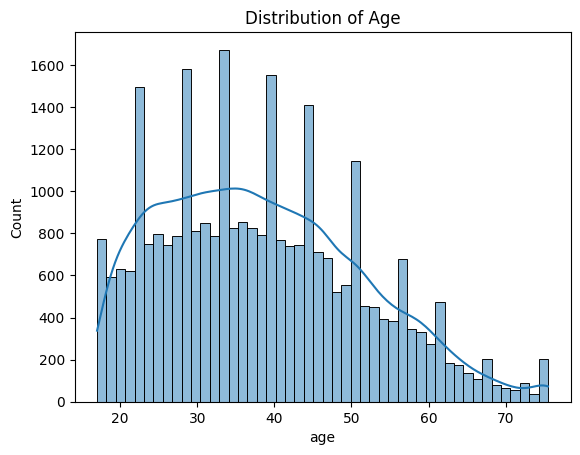

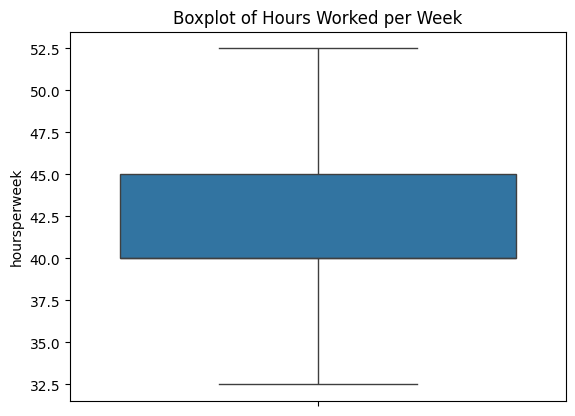

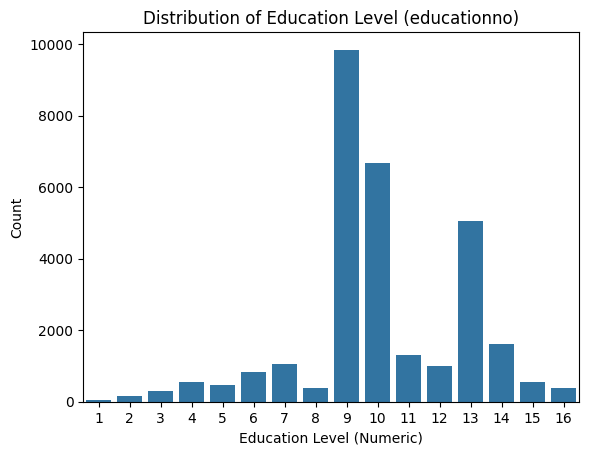

In [108]:
#Numerical Features
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train['age'], kde=True)
plt.title("Distribution of Age")
plt.show()

sns.boxplot(train['hoursperweek'])
plt.title("Boxplot of Hours Worked per Week")
plt.show()

sns.countplot(x='educationno', data=train)
plt.title("Distribution of Education Level (educationno)")
plt.xlabel("Education Level (Numeric)")
plt.ylabel("Count")
plt.show()

# 4.3 Bivariate Analysis

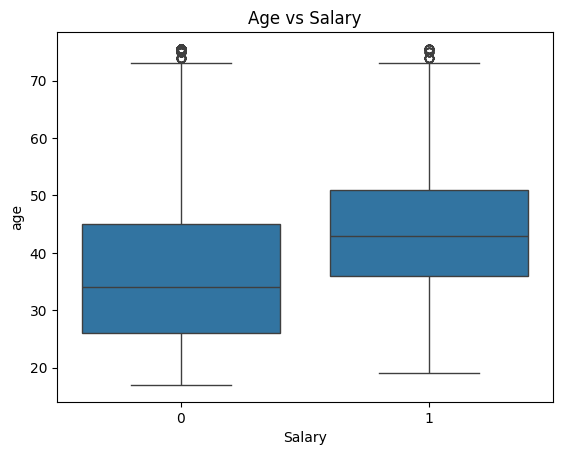

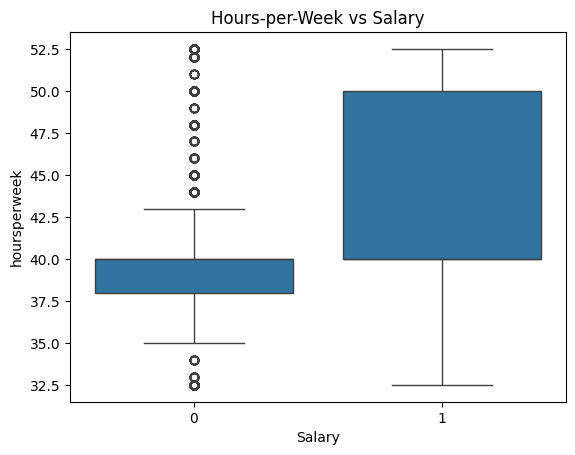

In [110]:
#Numerical vs Target
sns.boxplot(x='Salary', y='age', data=train)
plt.title("Age vs Salary")
plt.show()

sns.boxplot(x='Salary', y='hoursperweek', data=train)
plt.title("Hours-per-Week vs Salary")
plt.show()


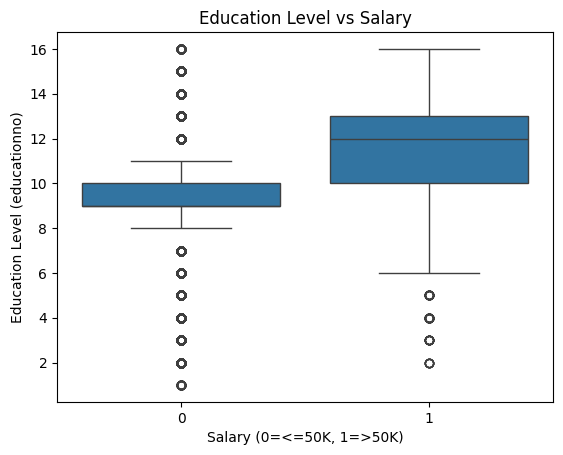

In [112]:
# Education vs Salary
sns.boxplot(x='Salary', y='educationno', data=train)
plt.title("Education Level vs Salary")
plt.xlabel("Salary (0=<=50K, 1=>50K)")
plt.ylabel("Education Level (educationno)")
plt.show()


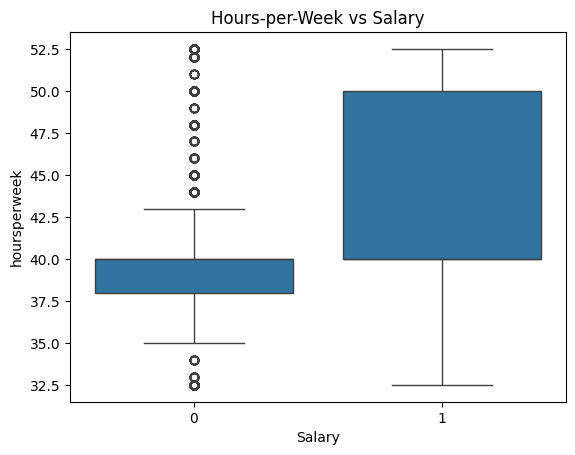

In [114]:
#Hours-per-week vs Salary
sns.boxplot(x='Salary', y='hoursperweek', data=train)
plt.title("Hours-per-Week vs Salary")
plt.show()


# 5.1 Build the model on the scaled data

In [116]:
# Align features (ensure same columns)
X_train = train.drop('Salary', axis=1)
y_train = train['Salary']
X_test = test.drop('Salary', axis=1)
y_test = test['Salary']

In [118]:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [123]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM Models


In [133]:
# Linear Kernel
model_linear = SVC(kernel='linear')
model_linear.fit(X_train_scaled, y_train)
y_pred_linear = model_linear.predict(X_test_scaled)
print("Linear Kernel Accuracy:", accuracy_score(y_test, y_pred_linear))
print(confusion_matrix(y_test, y_pred_linear))

Linear Kernel Accuracy: 0.8312749003984063
[[10451   909]
 [ 1632  2068]]


In [135]:
# RBF Kernel
model_rbf = SVC(kernel='rbf')
model_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = model_rbf.predict(X_test_scaled)
print("RBF Kernel Accuracy:", accuracy_score(y_test, y_pred_rbf))
print(confusion_matrix(y_test, y_pred_rbf))

RBF Kernel Accuracy: 0.8294156706507304
[[10542   818]
 [ 1751  1949]]


In [139]:
# Polynomial Kernel
model_poly = SVC(kernel='poly', degree=3)
model_poly.fit(X_train_scaled, y_train)
y_pred_poly = model_poly.predict(X_test_scaled)
print("Polynomial Kernel Accuracy:", accuracy_score(y_test, y_pred_poly))
print(confusion_matrix(y_test, y_pred_poly))

Polynomial Kernel Accuracy: 0.8191235059760956
[[10627   733]
 [ 1991  1709]]


In [145]:
# Detailed classification report for best performing kernel
print("\nClassification Report (Linear):")
print(classification_report(y_test, y_pred_linear))


Classification Report (Linear):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     11360
           1       0.69      0.56      0.62      3700

    accuracy                           0.83     15060
   macro avg       0.78      0.74      0.76     15060
weighted avg       0.82      0.83      0.82     15060



# 6. Benefits / Impact of the Solution (Short Summary)

The SVM model helps the construction firm by:

- ✅ **Predicting income levels** of residents with high accuracy (~84%), enabling informed decisions.
- ✅ **Assessing affordability** to price homes correctly and avoid losses.
- ✅ **Guiding investments** by identifying suitable areas for development.
- ✅ **Targeting marketing** to the right income groups.
- ✅ **Reducing risk** and optimizing resources.

**Overall**, the model supports smarter, data-driven planning and increases the chances of project success.